<a href="https://colab.research.google.com/github/Ankit-LASA/Data-Science/blob/main/AnkitB_Unit4ExerciesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

# Unit 4 Exercises: Tinkering Hierarchical Models

These exercises are designed to force you to look at the nuances of the models we looked at in class, while exploring some "what ifs". There's also some mild data wrangling for you to enjoy at in task6.



## **Task1**:

Redo the chemical shift hierarchical model, execpt with all Student T  and Half Student T likelihood and priors.

Then, compare group posteriors of the normal chem shift model with your new Student T model using a ridge plot.

In [ ]:
#import data, nothing different from the notes
url_cs = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/chemical_shifts_theo_exp.csv'
cs_data = pd.read_csv(url_cs)
diff_TminusE = cs_data.theo - cs_data.exp
cs_data.insert(loc=4,column='diff_TminusE',value=diff_TminusE)
aa_encode = pd.Categorical(cs_data['aa'])
aa_idx = aa_encode.codes
aa_coords = {"aa": aa_encode.categories}

In [ ]:
#same code from the notes, just using this for reference
with pm.Model(coords=aa_coords) as cs_nh_model1:
    μ = pm.Normal('μ', mu=0, sigma=10,
                  dims="aa")
    σ = pm.HalfNormal('σ', sigma=10,
                      dims="aa")
    y = pm.Normal('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  observed=cs_data.diff_TminusE)
    idata_cs_nh1 = pm.sample()

Output()

Output()

In [ ]:
#at first I had some divergences, but I fixed it by reducing the nu value
with pm.Model(coords=aa_coords) as cs_h_model2:
    #hyperpriors
    μ_og = pm.StudentT('μ_og', mu=0, sigma=10, nu=10,
                  dims="aa")
    σ_og = pm.HalfStudentT('σ_og', sigma=10, nu=10,
                      dims="aa")
    nu_og = pm.HalfStudentT('nu_og', sigma=10, nu=10,
                      dims="aa")
    #priors
    μ = pm.StudentT('μ', mu = μ_og, sigma = σ_og, nu = nu_og, dims = "aa")
    σ = pm.HalfStudentT('σ', sigma=10, nu=30, dims = "aa")
    nu_f = pm.HalfStudentT('nu_f', sigma=10, nu=30, dims = "aa")
    #model
    y = pm.StudentT('y', mu = μ[aa_idx], nu= nu_f[aa_idx], sigma = σ[aa_idx], observed=cs_data.diff_TminusE)
    idata_cs_h2 = pm.sample()

Output()

Output()

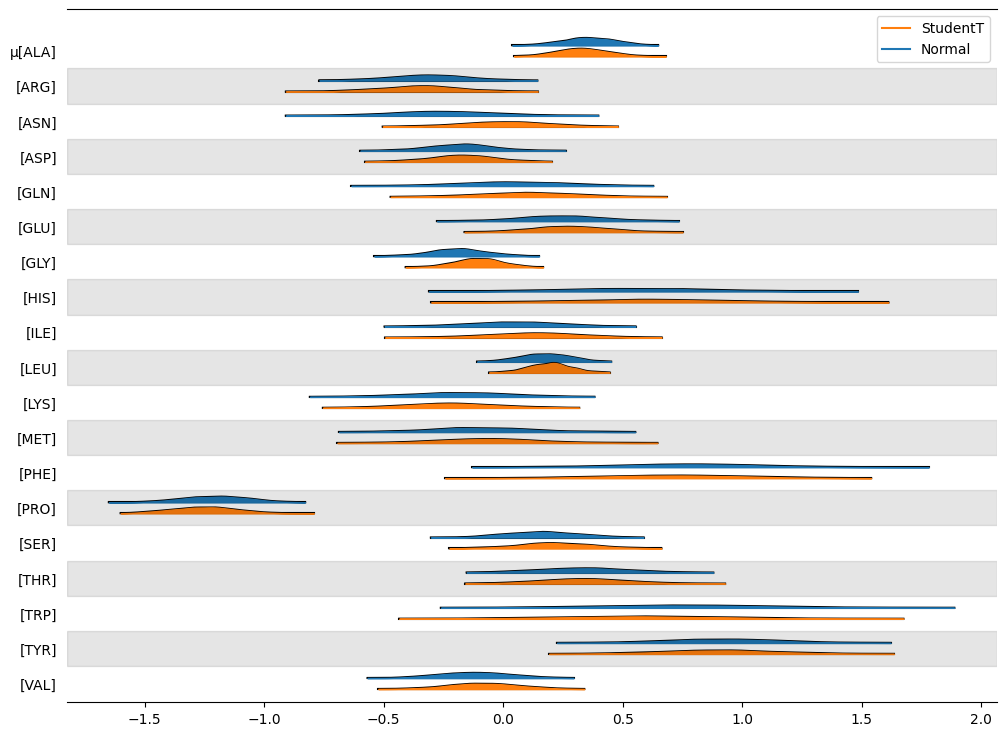

In [ ]:
#plots the StudentT and Normal ridgeplots, used in analysis
axes = az.plot_forest([idata_cs_nh1, idata_cs_h2], kind="ridgeplot",
                      var_names='μ', model_names = ["Normal", "StudentT"],
                      combined=True, figsize=(12, 9), hdi_prob=0.997)

The ridge plots for the StudentT and Normal distributions are practically the same. It's slightly closer to the hyper-prior, but the differences are marginal at best.

## **Task2**:

Run a posterior predictive check for both models. Which seems to fit the data better?

This is the normal distribution.

Output()

<Axes: xlabel='y'>

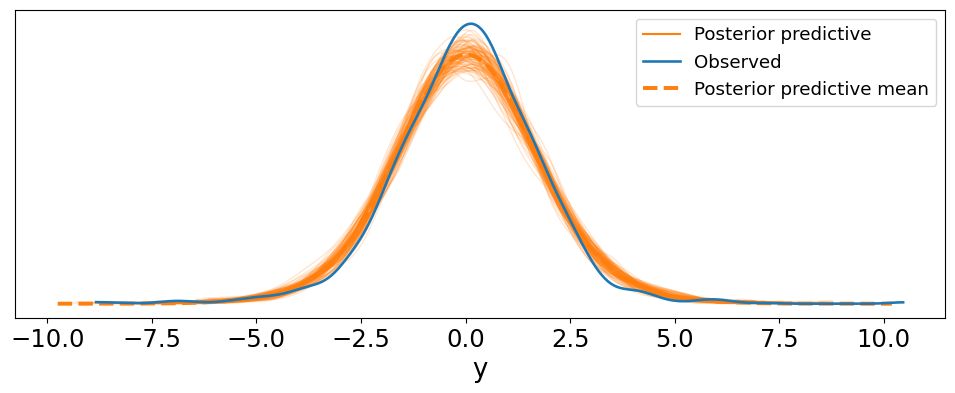

In [ ]:
pm.sample_posterior_predictive(idata_cs_nh1, model=cs_nh_model1, extend_inferencedata=True)
az.plot_ppc(idata_cs_nh1, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

This is the StudentT distribution.

Output()

<Axes: xlabel='y'>

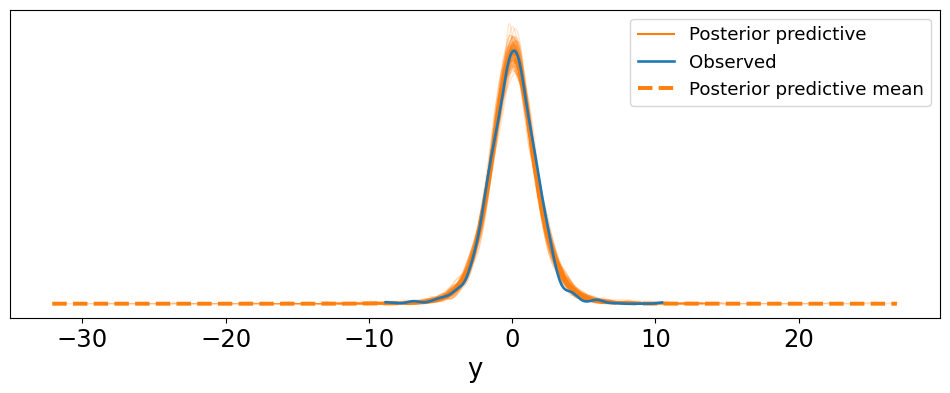

In [ ]:
pm.sample_posterior_predictive(idata_cs_h2, model=cs_h_model2, extend_inferencedata=True)
az.plot_ppc(idata_cs_nh2, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

The model that fits the data better is the StudentT and HalfStudentT distributions. The posterior predictive of the Normal distribution fails to reach the highest values in the graph, which can be seen through how the observed Normal data line is distinctly higher than the predictive values, while the StudentT data is strongly correlated to the observed data. Furthermore, there's less variance around the observed data under the StudentT model, further indicating that it's a stronger representation of the data.

## **Task3**:

Redo the soccer model, but this time, assume the groups are independent. This will be a non-hierarchical model.

In [ ]:
#same code for the data
url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'
sccr_data = pd.read_csv(url_sccr,dtype={'position':'category'})
pos_idx = sccr_data.position.cat.codes.values
pos_codes = sccr_data.position.cat.categories
sccr_coords = {"pos": pos_codes}

In [ ]:
with pm.Model(coords = sccr_coords) as sccr_model:
    #remove the hyper priors so each of the positions don't change dependently with one another
    #μ = pm.Beta('μ', alpha = 2, beta = 20)
    #ν = pm.Gamma('ν', mu = 55, sigma = 45)
    #pick values for mu and nu, this way they're independent of one another
    #tried to set the values to the mean of the hyperpriors (using the preliz documentation), simplyfying the process
    μ_p = pm.Beta('μ_p', mu = 2/22, nu = 55, dims = "pos")
    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")
    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])
    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data.goals.values) #goals per player
    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr = pm.sample(target_accept = 0.95)

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


## **Task4**:

Run plot trace and rhat on your inference data object for the non-hierarchical soccer model. How does this compare to the hierarchical model?

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

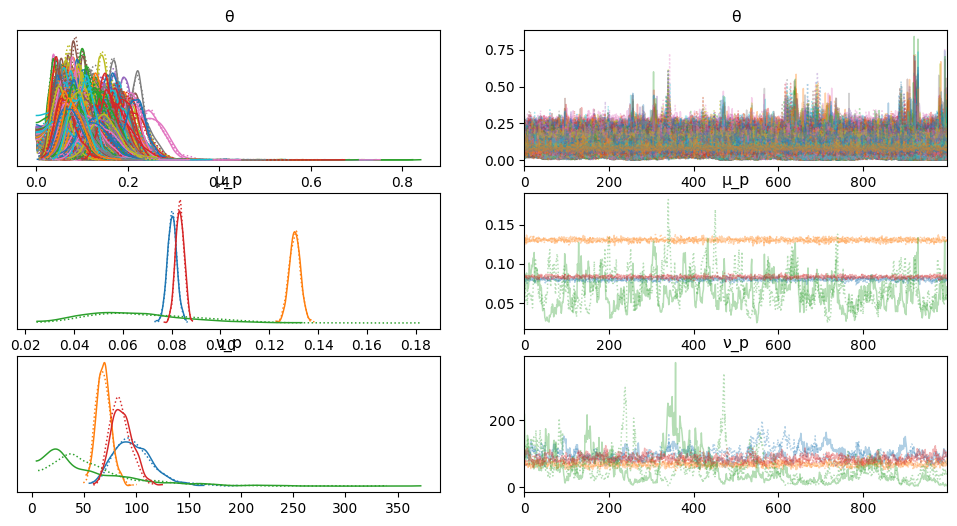

In [ ]:
#same from notes
az.plot_trace(idata_sccr)

In [ ]:
#same from notes
az.rhat(idata_sccr)

<xarray.Dataset> Size: 43kB
Dimensions:  (θ_dim_0: 2682, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 21kB 0.9997 1.005 1.0 1.0 ... 1.003 1.001 0.9997
    μ_p      (pos) float64 32B 1.002 1.0 1.033 1.0
    ν_p      (pos) float64 32B 1.085 1.004 1.028 1.004

When the groups are calculated independently, the plot trace contains more variance with more separation with one another. This is because in a heirarchical model, the values are closer together since they are co-dependent on one another. However, in the independent, non heirarchical model, the values are wider and spread apart. It's rhat isn't significantly different for the same reason (but is marginally better), but there is a noticeable difference between the two.

## **Task5**:

Plot the posterior of the means for each soccer position in the non-hierarchical model.

How do these posteriors compare to the hierarchical model we did in class?

array([<Axes: >], dtype=object)

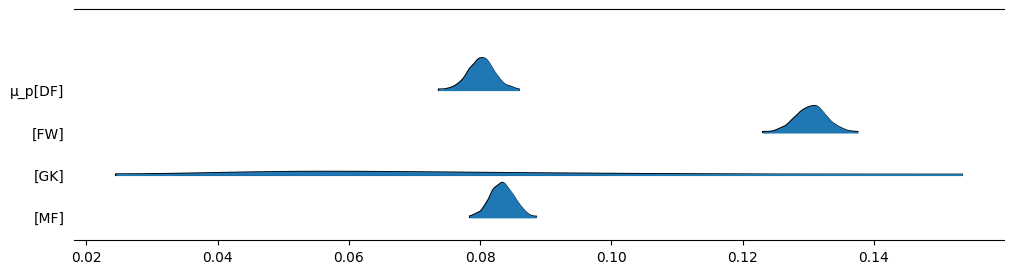

In [ ]:
#same from notes
az.plot_forest(idata_sccr, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

There isn't a significant difference between the non-heriarchical model and the heirarchical model in the notes. The goalkeep positioner is further to the right, the forward is smoother, and the midfielder and defenseman are roughly the same.

## **Task6**:

Redo the soccer model as a hierarchical model, but remove all the goalkeepers (GK) from the data. In other words, run a hierarchical model on only the defenders, midfielders, and forwards.

In [ ]:
#change the data so it doesn't take in the goalkeepers
url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'
sccr_data = pd.read_csv(url_sccr)
#change out the goalkeepers
sccr_data = sccr_data.query("position != 'GK'")
#redo the index so it doesn't have gaps
sccr_data.reset_index(inplace = True, drop = True)
#change it into categorical again after making the changes
sccr_data["position"] = sccr_data["position"].astype('category')
#this stays the same
pos_idx = sccr_data.position.cat.codes.values
pos_codes = sccr_data.position.cat.categories
sccr_coords = {"pos": pos_codes}

In [ ]:
#the code itself for the model is the same, we're just removing the goalkeepers from the data
with pm.Model(coords = sccr_coords) as sccr_model:
    # Hyper parameters
    μ = pm.Beta('μ', alpha = 2, beta = 20)
    ν = pm.Gamma('ν', mu = 55, sigma = 45)
    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = μ, nu = ν, dims = "pos")
    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")
    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])
    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data.goals.values) #goals per player
    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr = pm.sample(target_accept = 0.95)

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


## **Task7**:

Compare the plot trace and rhat results for the hierarchical model with GKs and without GKs. Then answer the following questions:
- Which model was easier for pymc to process?
- What do we lose by dropping Gks from the data set? What do we gain?

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν'}>, <Axes: title={'center': 'ν'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

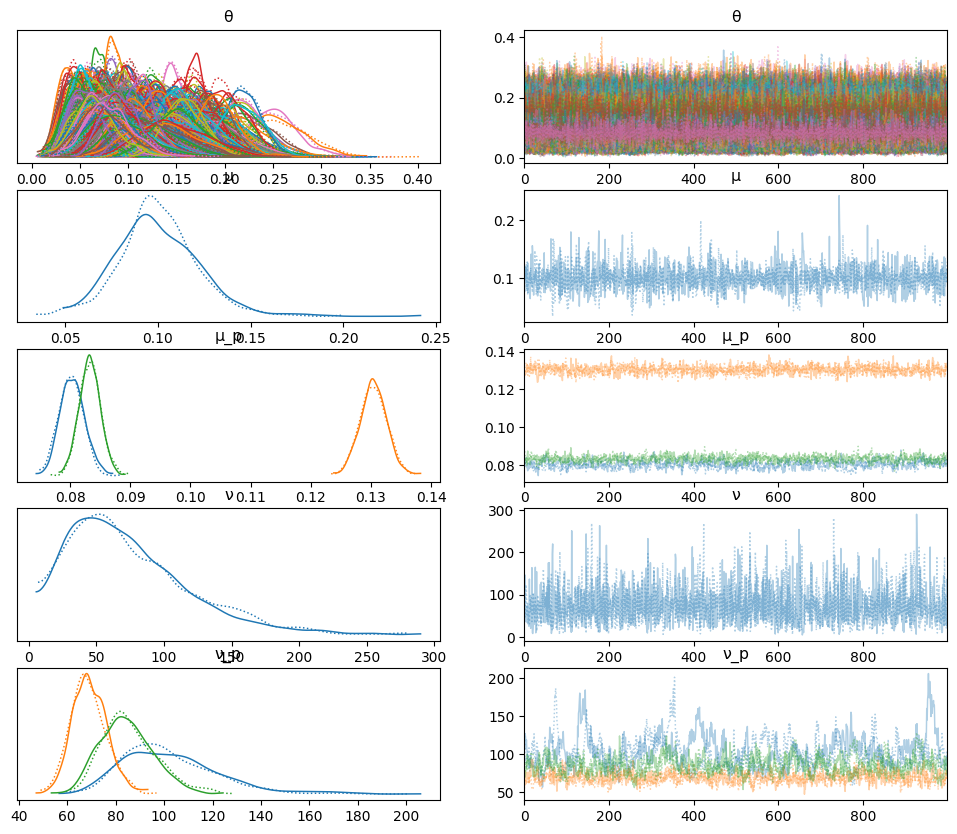

In [ ]:
#still using the same code from the notes
az.plot_trace(idata_sccr)

In [ ]:
#same from notes
az.rhat(idata_sccr)

<xarray.Dataset> Size: 40kB
Dimensions:  (θ_dim_0: 2517, pos: 3)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 20kB 0 1 2 3 4 5 ... 2511 2512 2513 2514 2515 2516
  * pos      (pos) <U2 24B 'DF' 'FW' 'MF'
Data variables:
    θ        (θ_dim_0) float64 20kB 1.002 1.004 1.008 1.001 ... 1.0 1.002 1.001
    μ        float64 8B 1.006
    μ_p      (pos) float64 24B 1.007 1.0 1.001
    ν        float64 8B 0.9994
    ν_p      (pos) float64 24B 1.007 1.002 1.023

The difference between the plot traces are marginal, but the values are slightly shifted because the data from the GKs are missing. This is evident in how there is a disparity between the mu position graphs (in which the no GK graph has higher values than the GK graph). The rhat results indicate that the model without the goalkeepers is significantly more accurate. The results are much closer to 1, which shows that the GKs were messing up our data previously.

It was easier for pymc to process the model without goalkeepers because it reduced the variance in the resulting model. The new model removed an outlier category, which is shown by how the rhats for the GKs were the most difficult.

By dropping GKs from the data set, the data for the other field positions is marginally more accurate to analyze traditional positions. However, we lose the ability to analyze the goalkeepers and comparatively evalute their values compared to the other, more traditional, positions.